In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
gnn.config.set_gpu(False)

In [3]:
model_paths = [
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_0/checkpoints/epoch=12-step=4692.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_1/checkpoints/epoch=13-step=5053.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_2/checkpoints/epoch=19-step=7219.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_3/checkpoints/epoch=22-step=8302.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_4/checkpoints/epoch=14-step=5414.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_5/checkpoints/epoch=19-step=7219.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_6/checkpoints/epoch=15-step=5775.ckpt",
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_7/checkpoints/epoch=9-step=3609.ckpt",
]


In [4]:
model = gnn.modelMap['golden_knn'].load_from_checkpoint(model_paths[0]).to(device=gnn.config.device)

In [5]:
from torch_geometric.data import Data 

class ModelPredict(gnn.BaseTransform):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def __call__(self, data : Data) -> Data:
        node_o, edge_o = model.predict(data.to(model.device))
        data.node_o = node_o
        data.edge_o = edge_o
        return data

In [6]:
template = gnn.Dataset("../data/template",make_template=True, transform=gnn.min_edge_neighbor(n_neighbor=model.hparams['n_neighbor']))
template.transform.append(ModelPredict(model))

In [7]:
bkgtrees = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [8]:
# signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])
signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])

In [9]:
for tree in signaltrees: tree.color=None

In [10]:
def get_tree_graph(tree, ver='testing', path='../data'):
    sample = tree.sample
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

def get_qcd_graph(tree, path='../data'):
    get_name = lambda f : f.fname.split('/')[-2]
    dataset = gnn.concat_dataset([f'{path}/{sample}' for sample in map(get_name, tree.filelist)],transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [11]:
signaltrees.apply(get_tree_graph)
bkgtrees.apply(get_qcd_graph)

[None]

In [26]:

from torch_geometric.utils import to_networkx
import networkx as nx
def mask_graph(data, edge_mask):
    data = data.clone()
    data.edge_index = data.edge_index[:,edge_mask]
    data.edge_attr = data.edge_attr[edge_mask]
    return data

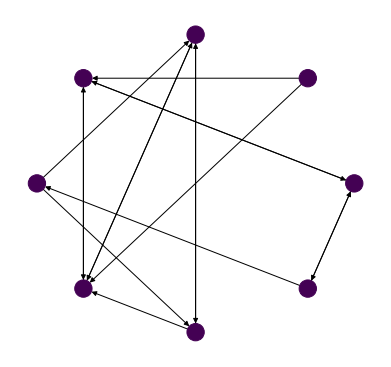

In [30]:
data = bkgtrees[0].graphs.dataset[100]
nx.draw_circular(to_networkx( mask_graph(data,data.edge_mask), remove_self_loops=True), node_color=(data.node_id+1)//2)

In [12]:
(bkgtrees+signaltrees).apply(build_all_dijets)

[None, None, None, None]

In [13]:
def assign_dijet_scores(tree):
    n_edges = ak.num(tree.dijet_pt, axis=-1)

    itoj_score, jtoi_score = torch.Tensor([]), torch.Tensor([])
    for batch in tree.graphs:
        itoj = batch.edge_index[0] < batch.edge_index[1]
        jtoi = batch.edge_index[1] < batch.edge_index[0]
        jtoi_idx = (batch.num_nodes*batch.edge_index[1,jtoi] + batch.edge_index[0,jtoi]).argsort()

        itoj_score = torch.cat([itoj_score, batch.edge_o[itoj]])
        jtoi_score = torch.cat([jtoi_score, batch.edge_o[jtoi][jtoi_idx]])

    itoj_score = ak.unflatten(itoj_score.numpy(), n_edges)
    jtoi_score = ak.unflatten(jtoi_score.numpy(), n_edges)

    tree.extend(
        dijet_itoj_score=itoj_score,
        dijet_jtoi_score=jtoi_score
    )

In [14]:
(bkgtrees+signaltrees).apply(assign_dijet_scores)

[None, None, None, None]

In [15]:
def get_max_score(tree):
    itoj_score = tree.dijet_itoj_score
    jtoi_score = tree.dijet_jtoi_score

    score = ak.concatenate([itoj_score[:,:,None],jtoi_score[:,:,None]], axis=-1)
    score = ak.max(score,axis=-1)
    tree.extend(dijet_score=score)
(bkgtrees+signaltrees).apply(get_max_score)

[None, None, None, None]

In [16]:
(bkgtrees+signaltrees).apply(lambda t:select_higgs(t, field='itoj_score',tag='gnn_itoj', nhiggs=4))
(bkgtrees+signaltrees).apply(lambda t:select_higgs(t, field='jtoi_score',tag='gnn_jtoi', nhiggs=4))
(bkgtrees+signaltrees).apply(lambda t:select_higgs(t, field='score',tag='gnn', nhiggs=4))

[None, None, None, None]

In [17]:
(bkgtrees+signaltrees).extend(kwargs=lambda t:
dict(
    nfound_itoj=ak.sum(t.gnn_itoj_higgs_signalId>-1, axis=-1),
    nfound_jtoi=ak.sum(t.gnn_jtoi_higgs_signalId>-1, axis=-1),
    nfound_gnn=ak.sum(t.gnn_higgs_signalId>-1, axis=-1),
    ))

[None, None, None, None]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


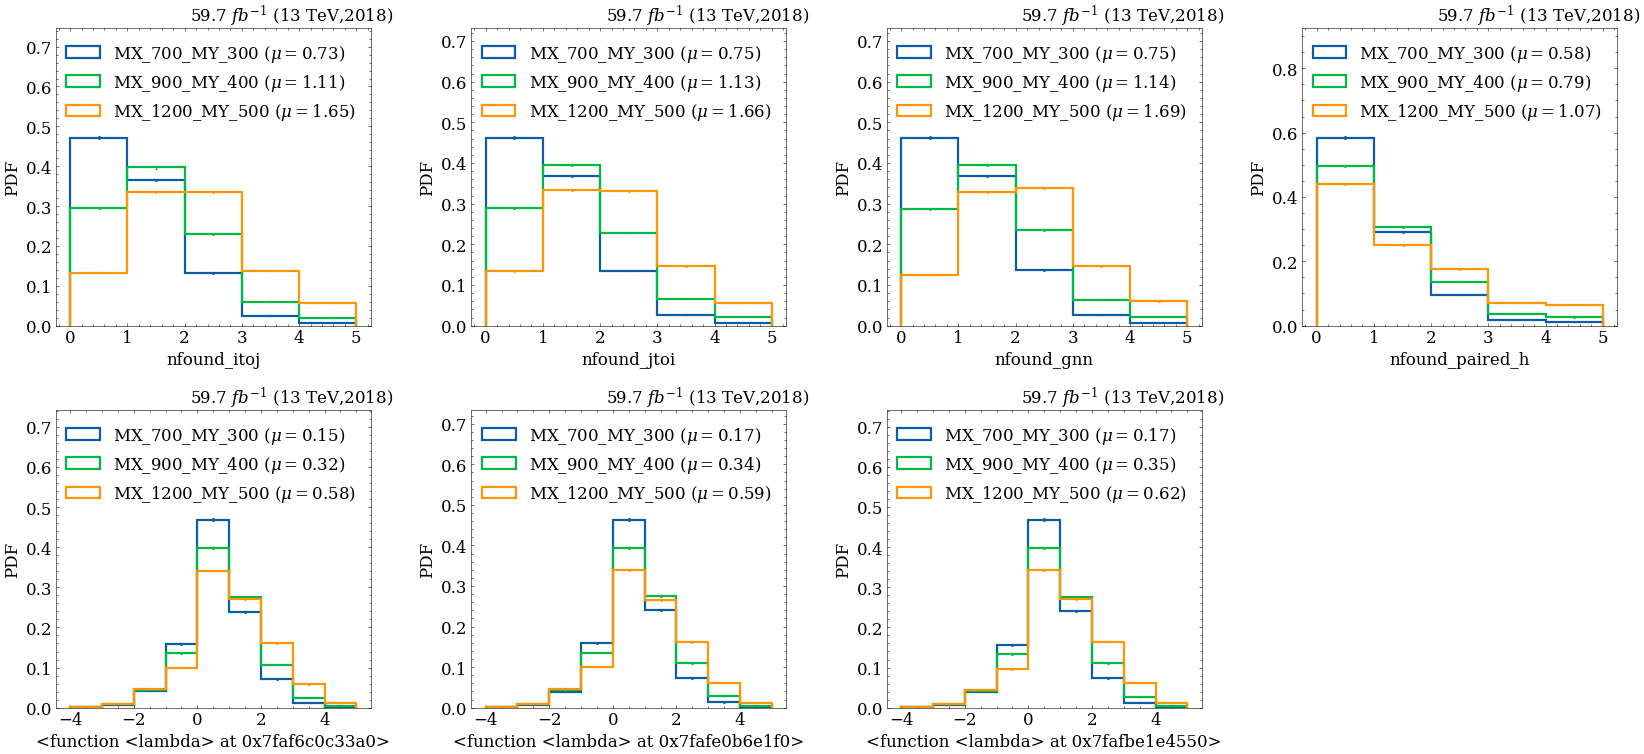

In [18]:
study.quick(
    signaltrees,
    varlist=[
        'nfound_itoj','nfound_jtoi','nfound_gnn','nfound_paired_h',
        lambda t:t.nfound_itoj-t.nfound_paired_h,lambda t:t.nfound_jtoi-t.nfound_paired_h,lambda t:t.nfound_gnn-t.nfound_paired_h,None
    ],
    # cumulative=-1,
    dim=(-1,4), density=True,
    h_label_stat='mean', legend=True,
)

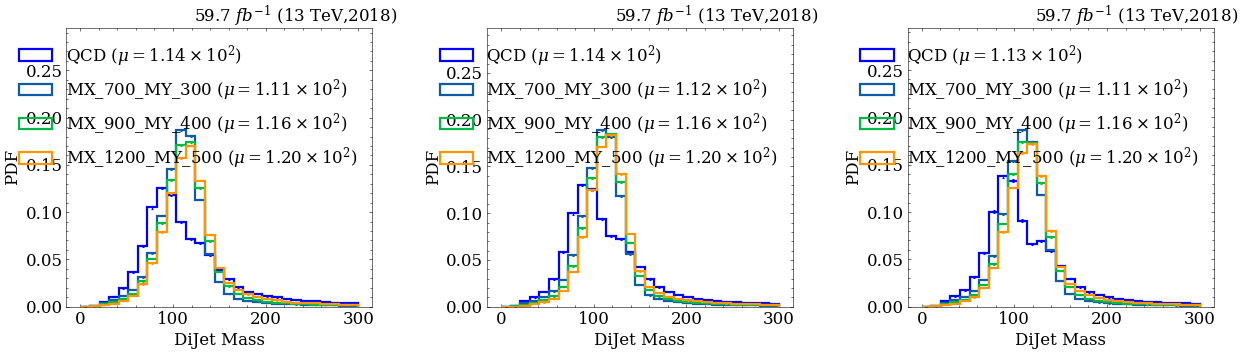

In [19]:
study.quick(
    bkgtrees+signaltrees,
    varlist=[
        'gnn_itoj_higgs_m','gnn_jtoi_higgs_m','gnn_higgs_m',
    ],
    # cumulative=-1,
    dim=(-1,3), density=True,
    h_label_stat='mean', legend=True,
)

In [20]:
def get_m_asym(higgs_m):
    maxim = ak.max(higgs_m,axis=-1)
    minim = ak.min(higgs_m,axis=-1)
    return (maxim-minim)/(maxim+minim)
itoj_m_asym = lambda t : get_m_asym(t.gnn_itoj_higgs_m)
jtoi_m_asym = lambda t : get_m_asym(t.gnn_jtoi_higgs_m)
gnn_m_asym  = lambda t : get_m_asym(t.gnn_higgs_m)


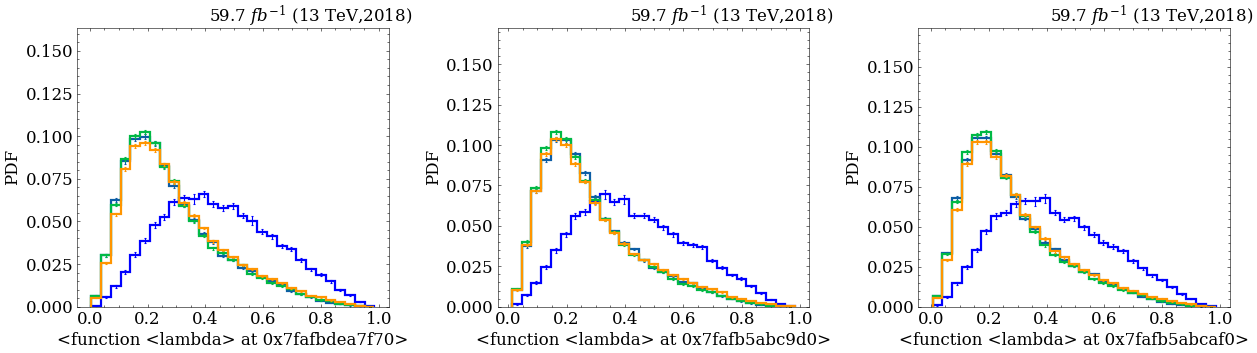

In [23]:
study.quick(
    bkgtrees+signaltrees,
    varlist=[
        itoj_m_asym, jtoi_m_asym, gnn_m_asym
    ],
    dim=(-1,3), density=True,

    # cumulative=1,correlation=True
)
